**Phase 1: Setup & Data Preparation**

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Installing CatBoost and SHAP for advanced modeling and explainability
!pip install catboost shap -q

# Import Libraries
import pandas as pd
import numpy as np
import warnings

# Suppress warnings for a cleaner output
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:00


In [6]:
# Load Data from Drive ---
file_path = "/content/drive/MyDrive/WA_Fn-UseC_-Telco-Customer-Churn.csv"

try:
    df = pd.read_csv(file_path)
    print("✅ Data loaded successfully!")
    print(f"Dataset Shape: {df.shape}")
except FileNotFoundError:
    print("❌ ERROR: File not found! Please check the file path.")

✅ Data loaded successfully!
Dataset Shape: (7043, 21)


In [7]:
# Advanced Data Preprocessing

def clean_data(df):
    """
    Cleans the raw dataframe:
    - Converts 'TotalCharges' to numeric (handling errors).
    - Encodes the target variable 'Churn'.
    - Drops unnecessary columns like IDs.
    """
    df = df.copy()

    # 'TotalCharges' contains empty strings, force convert to numeric
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

    # Fill NaN values (caused by empty strings) with the median
    df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

    # Encode Target Variable: Yes -> 1, No -> 0
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

    # Drop unique identifiers as they don't provide predictive value
    if 'customerID' in df.columns:
        df = df.drop('customerID', axis=1)

    return df

# Apply cleaning
if 'df' in locals():
    df_clean = clean_data(df)

    # Automatically detect categorical features for CatBoost
    categorical_features = df_clean.select_dtypes(include=['object']).columns.tolist()

    print("\n--- Preprocessing Complete ---")
    print(f"Categorical Features Detected ({len(categorical_features)}): {categorical_features}")
    print("First 5 rows preview:")
    display(df_clean.head())


--- Preprocessing Complete ---
Categorical Features Detected (15): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
First 5 rows preview:


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


**Phase 2: Advanced Model Training (CatBoost)**

In [8]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Prepare Features (X) and Target (y)
X = df_clean.drop('Churn', axis=1)
y = df_clean['Churn']

# Stratified Train-Test Split
# We use 'stratify=y' to maintain the same churn ratio in both sets.
# This is crucial for imbalanced datasets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training Set Shape: {X_train.shape}")
print(f"Test Set Shape: {X_test.shape}")

# Initialize CatBoost
model = CatBoostClassifier(
    iterations=1000,            # Max number of trees
    learning_rate=0.05,         # Step size shrinkage
    depth=6,                    # Depth of the tree
    eval_metric='AUC',          # Area Under Curve is better for imbalance than Accuracy
    auto_class_weights='Balanced', # Automatically handles imbalanced data!
    verbose=200,                # Log output every 200 iterations
    random_seed=42
)

# Train the Model
print("\nStarting Training...")
model.fit(
    X_train, y_train,
    cat_features=categorical_features,
    eval_set=(X_test, y_test),
    early_stopping_rounds=50,   # Stop if validation score doesn't improve for 50 rounds
    plot=False
)

# Evaluate Performance
y_pred = model.predict(X_test)

print("\n--- Model Evaluation Report ---")
print(classification_report(y_test, y_pred))

# Check Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Training Set Shape: (5634, 19)
Test Set Shape: (1409, 19)

Starting Training...
0:	test: 0.8189387	best: 0.8189387 (0)	total: 130ms	remaining: 2m 9s
200:	test: 0.8446098	best: 0.8452724 (157)	total: 8.29s	remaining: 33s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8452724173
bestIteration = 157

Shrink model to first 158 iterations.

--- Model Evaluation Report ---
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1035
           1       0.52      0.80      0.63       374

    accuracy                           0.75      1409
   macro avg       0.71      0.77      0.72      1409
weighted avg       0.81      0.75      0.76      1409

Confusion Matrix:
[[757 278]
 [ 75 299]]


In [11]:
from sklearn.metrics import f1_score, classification_report
import numpy as np

# Calculate Probabilities
# We need to get the probability of Churn (1) for the test set
y_prob = model.predict_proba(X_test)[:, 1]

# Threshold Optimization Strategy
# We test all thresholds from 0.1 to 0.9 to find the best balance
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = []

for t in thresholds:
    # Generate predictions (1 or 0) based on the current threshold 't'
    y_pred_temp = (y_prob >= t).astype(int)

    # Calculate F1 Score (Harmonic mean of Precision and Recall)
    score = f1_score(y_test, y_pred_temp)
    f1_scores.append(score)

# Find the Best Threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"🏆 Optimal Threshold: {best_threshold:.2f}")
print(f"🏆 Max F1 Score: {best_f1:.2f}")

# Final Evaluation with Optimal Threshold
final_preds = (y_prob >= best_threshold).astype(int)

print("\n--- Final Optimized Report ---")
print(classification_report(y_test, final_preds))

🏆 Optimal Threshold: 0.56
🏆 Max F1 Score: 0.64

--- Final Optimized Report ---
              precision    recall  f1-score   support

           0       0.90      0.78      0.84      1035
           1       0.56      0.75      0.64       374

    accuracy                           0.78      1409
   macro avg       0.73      0.77      0.74      1409
weighted avg       0.81      0.78      0.78      1409



**Phase 3: Explainable AI with SHAP**

⏳ Calculating SHAP values... (This might take a moment)

📊 1. Global Feature Importance (Summary Plot)
Showing which features have the biggest impact on Churn globally.
(Red dots = High feature value, Blue dots = Low feature value)


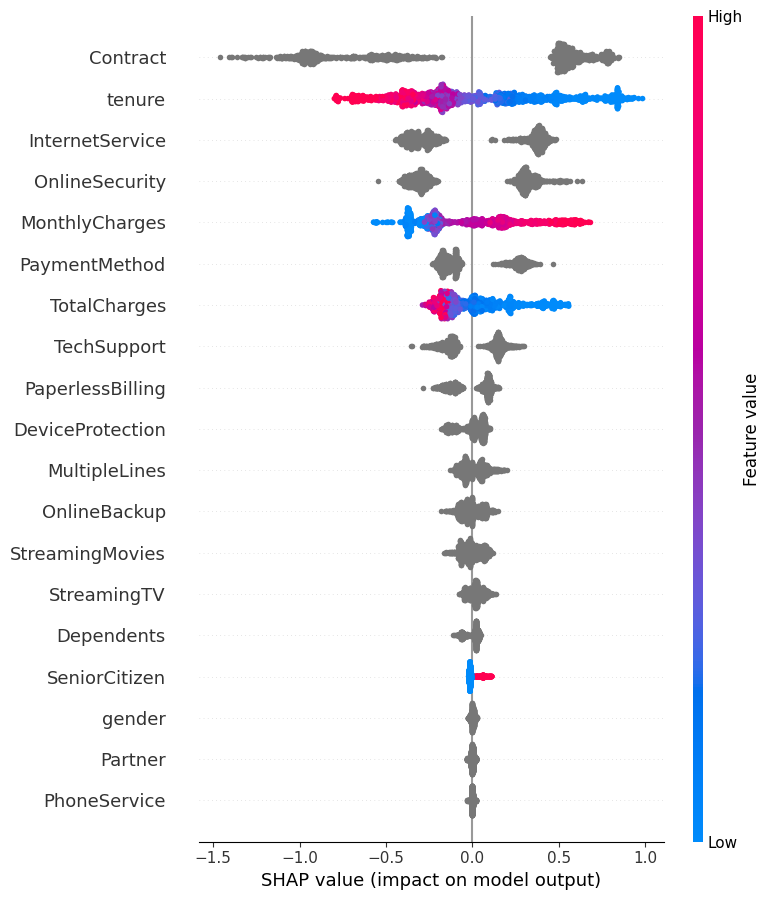


🔍 2. Local Explanation for Customer Index: 1
Model Probability: 0.87 (Threshold: 0.56)
Why is this customer at risk? (Red bars push risk UP, Blue bars push risk DOWN)


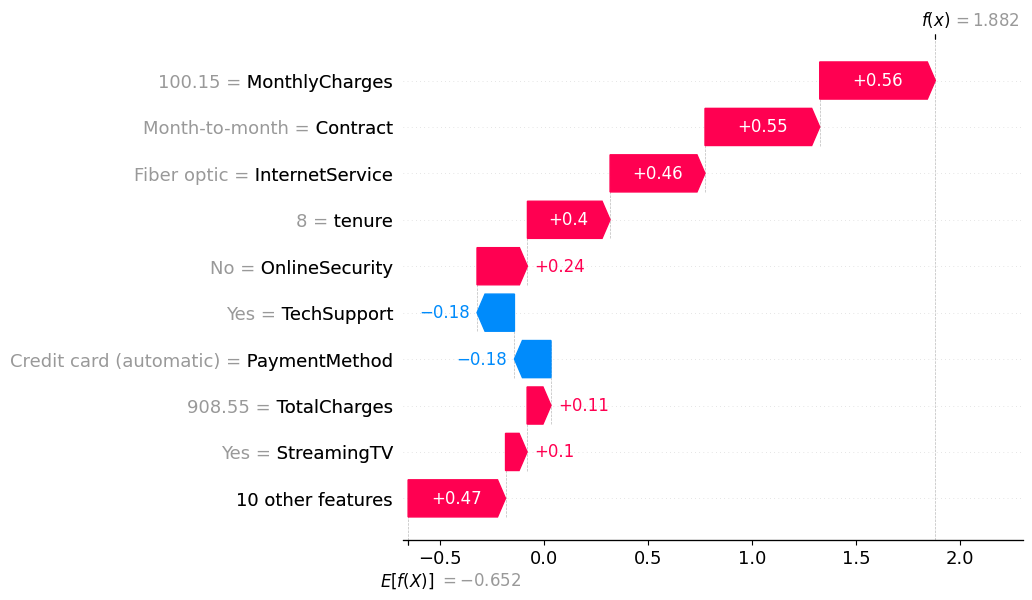

In [12]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# Initialize the SHAP Explainer
# TreeExplainer is optimized for gradient boosting models like CatBoost
print("⏳ Calculating SHAP values... (This might take a moment)")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Global Interpretability (Summary Plot)
print("\n📊 1. Global Feature Importance (Summary Plot)")
print("Showing which features have the biggest impact on Churn globally.")
print("(Red dots = High feature value, Blue dots = Low feature value)")

plt.figure(figsize=(10, 6))
# max_display limits the plot to top 20 features for better readability
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, show=False)
plt.show()

# Local Interpretability (Waterfall Plot)
# Let's find a customer who is predicted as CHURN based on our optimized threshold
# We use the probabilities and the 'best_threshold' calculated in the previous step
y_prob_test = model.predict_proba(X_test)[:, 1]

# Find indices where probability > best_threshold (High Risk Customers)
high_risk_indices = np.where(y_prob_test > best_threshold)[0]

if len(high_risk_indices) > 0:
    # Pick the first high-risk customer found in the test set
    customer_idx = high_risk_indices[0]

    print(f"\n🔍 2. Local Explanation for Customer Index: {customer_idx}")
    print(f"Model Probability: {y_prob_test[customer_idx]:.2f} (Threshold: {best_threshold:.2f})")
    print("Why is this customer at risk? (Red bars push risk UP, Blue bars push risk DOWN)")

    # Visualize the decision path for this specific customer
    plt.figure(figsize=(8, 6))
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values[customer_idx],
            base_values=explainer.expected_value,
            data=X_test.iloc[customer_idx],
            feature_names=X_test.columns
        )
    )
else:
    print("No high-risk customers found in the test set with the current threshold.")